In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
air = pd.read_csv(r'C:\Users\abhay.jamwal\Downloads\original\UDEMY_TSA_FINAL\Data\airline_passengers.csv',index_col='Month',
                 parse_dates=True)

In [5]:
air.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [6]:
rolmean = air.rolling(window=12).mean()
rolstd = air.rolling(window=12).std()

C:\Users\abhay.jamwal\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


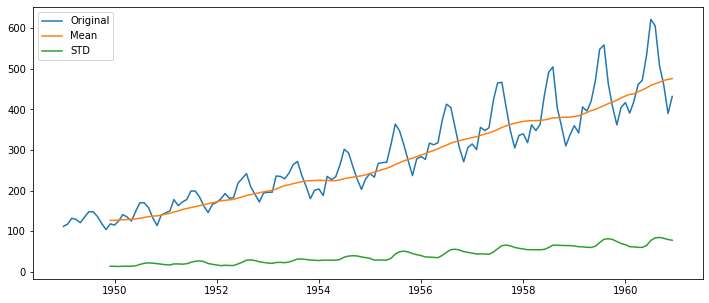

In [7]:
plt.figure(figsize=(12,5))
orig = plt.plot(air['Thousands of Passengers'],label = 'Original')
mean = plt.plot(rolmean,label = 'Mean')
std = plt.plot(rolstd,label = "STD")
plt.legend(loc = 'best')
plt.show()

# Dickey Fuller test

In [8]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA


In [9]:
print('Results of DF test')
air_test = adfuller(air['Thousands of Passengers'],autolag='AIC')
air_out = pd.Series(air_test[0:4],index=['Test Stat','P-value','#Lags used','No of observations used'])
for key,values in air_test[4].items():
    air_out['Critical Value of (%s) '%key] = values
print(air_out)

Results of DF test
Test Stat                     0.815369
P-value                       0.991880
#Lags used                   13.000000
No of observations used     130.000000
Critical Value of (1%)       -3.481682
Critical Value of (5%)       -2.884042
Critical Value of (10%)      -2.578770
dtype: float64


#### This is not stationary as this moment so we have to do some transformation to make it stationart. Lets start with Log transformation

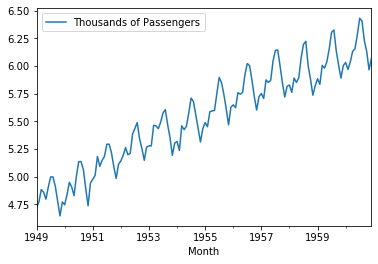

In [10]:
air_log = np.log(air)
air_log.plot()

In [11]:

moving_average = air_log.rolling(window=12).mean()
moving_std = air_log.rolling(window=12).std()

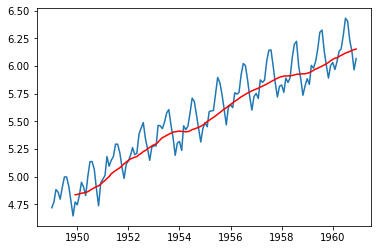

In [12]:
plt.plot(air_log)
plt.plot(moving_average,color = 'red')
#plt.plot(air_log_rolstd,color = 'green')

In [13]:
airlog_minus_movingaverage = air_log - moving_average
airlog_minus_movingaverage.dropna(inplace=True)

In [14]:
def test_stationary(timeseries):
    
    # moving averages and std
    moving_average = timeseries.rolling(12).mean()
    moving_std = timeseries.rolling(12).std()
    
   # plotting graphs
    orig = plt.plot(timeseries,color = 'red',label = 'ORIGINAL')
    mean = plt.plot(moving_average,color = 'green',label = 'Mean')
    std = plt.plot(moving_std,color = 'black',label = 'STD')
    plt.show()
    
    # Dickey Fuller test 
    print('Results of DF test')
    timeseries_test = adfuller(timeseries['Thousands of Passengers'],autolag='AIC')
    timeseries_out = pd.Series(timeseries_test[0:4],index=['Test Stat','P-value','#Lags used','No of observations used'])
    for key,values in timeseries_test[4].items():
        timeseries_out['Critical Value of (%s) '%key] = values
    print(timeseries_out)
    
    
    

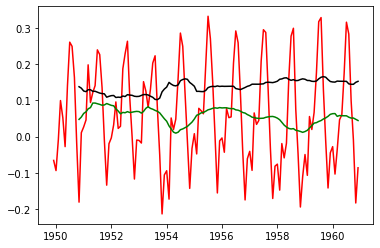

Results of DF test
Test Stat                    -3.162908
P-value                       0.022235
#Lags used                   13.000000
No of observations used     119.000000
Critical Value of (1%)       -3.486535
Critical Value of (5%)       -2.886151
Critical Value of (10%)      -2.579896
dtype: float64


In [15]:
test_stationary(airlog_minus_movingaverage)

## Exponential Decay Transformation

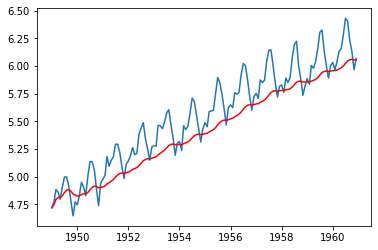

In [16]:
exp_weight_moving_avg = air_log.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.plot(air_log)
plt.plot(exp_weight_moving_avg,color = 'red')

In [17]:
air_log_MINUS_exp_weight_moving_avg = air_log - exp_weight_moving_avg

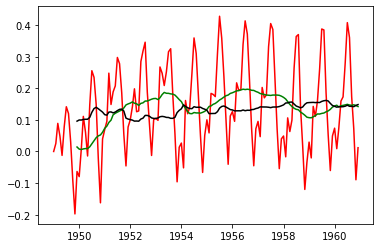

Results of DF test
Test Stat                    -3.601262
P-value                       0.005737
#Lags used                   13.000000
No of observations used     130.000000
Critical Value of (1%)       -3.481682
Critical Value of (5%)       -2.884042
Critical Value of (10%)      -2.578770
dtype: float64


In [18]:
test_stationary(air_log_MINUS_exp_weight_moving_avg)

## Time Shift Transformation

In [19]:
time_shift_trans = air_log - air_log.shift()

In [20]:
time_shift_trans.dropna(inplace=True)

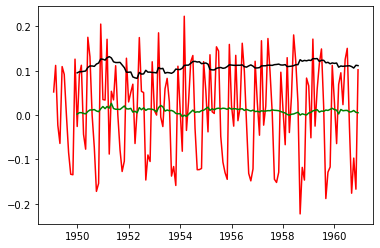

Results of DF test
Test Stat                    -2.717131
P-value                       0.071121
#Lags used                   14.000000
No of observations used     128.000000
Critical Value of (1%)       -3.482501
Critical Value of (5%)       -2.884398
Critical Value of (10%)      -2.578960
dtype: float64


In [21]:
test_stationary(time_shift_trans)

## Decomposition

In [22]:
#decom_1 = seasonal_decompose(air_log,model = 'add',period = 12)

In [23]:
decom = seasonal_decompose(air_log)

In [24]:
trend = decom.trend
seasonality = decom.seasonal
residual = decom.resid

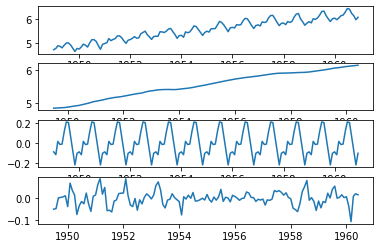

In [25]:
plt.subplot(411)
plt.plot(air_log,label = 'Original')

plt.subplot(412)
plt.plot(trend,label = 'Trend')

plt.subplot(413)
plt.plot(seasonality,label = 'Seasonality')

plt.subplot(414)
plt.plot(residual,label = 'Residual')

### Auto_Arima

In [60]:
air_log.shape

(144, 1)

In [61]:
train = air_log[:int(0.6*(len(air_log)))]
test = air_log[int(0.6*(len(air_log))):]

In [74]:
# train_air = air[:int(0.6*(len(air)))]
# test_air = air[int(0.6*(len(air))):]

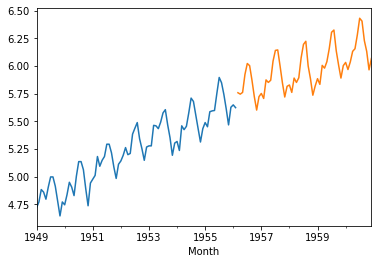

In [30]:
train['Thousands of Passengers'].plot()
test['Thousands of Passengers'].plot()

In [62]:
from pmdarima.arima import auto_arima

In [75]:
# m1 = auto_arima(train_air,trace=True,error_action='ignore',suppress_warnings=True,m = 12)

In [65]:
model = auto_arima(train,trace=True,error_action='ignore',suppress_warnings=True,seasonal=False)

Fit ARIMA: order=(2, 1, 2); AIC=-162.810, BIC=-148.154, Fit time=0.248 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-142.129, BIC=-137.244, Fit time=0.000 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-141.739, BIC=-134.411, Fit time=0.020 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-142.555, BIC=-135.227, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 2); AIC=-158.698, BIC=-146.484, Fit time=0.088 seconds
Fit ARIMA: order=(3, 1, 2); AIC=-161.149, BIC=-144.050, Fit time=0.374 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-160.445, BIC=-148.231, Fit time=0.204 seconds
Fit ARIMA: order=(2, 1, 3); AIC=-161.252, BIC=-144.153, Fit time=0.710 seconds
Fit ARIMA: order=(1, 1, 1); AIC=-150.783, BIC=-141.012, Fit time=0.074 seconds
Fit ARIMA: order=(3, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.837 seconds


In [66]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   85
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  87.405
Method:                       css-mle   S.D. of innovations              0.084
Date:                Tue, 10 Mar 2020   AIC                           -162.810
Time:                        19:40:42   BIC                           -148.154
Sample:                             1   HQIC                          -156.915
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0111      0.000     23.632      0.000       0.010       0.012
ar.L1.D.y      1.4346      0.106     13.556      0.000       1.227       1.642
ar.L2.D.y     -0.6989      0.081     -8.659      0.000      -0.857      -0.541
ma.L1.D.y     -1.6843      0.137    -12.266      0.000      -1.953      -1.415
ma.L2.D.y      0.6844      0.130      5.247      0.000       0.429       0.940
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0263           -0.6144j            1.1962           -0.0858
AR.2            1.0263           +0.6144j            1.1962            0.0858
MA.1            1.0001           +0.0000j            1.0001            0.0000
MA.2            1.4610           +0.0000j            1.4610            0.0000
-----------------------------------------------------------------------------
"""

In [36]:
model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 1),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

In [38]:
forcast = model.predict(n_periods=len(test))

In [42]:
forcast = pd.DataFrame(forcast,index = test.index,columns=['Prediction'])


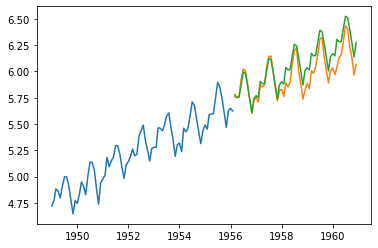

In [44]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forcast, label='Prediction')
plt.show()

In [45]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(test,forcast))
print(rms)

0.11124197503946534


### Fitting with Time shift model

In [47]:
time_shift_trans.shape

(143, 1)

In [50]:
train_time_shift = time_shift_trans[:int(0.6*len(time_shift_trans))]
test_time_shift = time_shift_trans[int(0.6*len(time_shift_trans)):]

In [51]:
model_2 = auto_arima(train_time_shift,seasonal=False,trace = True,error_action='ignore',suppress_warnings=True)

Fit ARIMA: order=(2, 0, 2); AIC=-162.810, BIC=-148.154, Fit time=0.279 seconds
Fit ARIMA: order=(0, 0, 0); AIC=-142.129, BIC=-137.244, Fit time=0.000 seconds
Fit ARIMA: order=(1, 0, 0); AIC=-141.739, BIC=-134.411, Fit time=0.016 seconds
Fit ARIMA: order=(0, 0, 1); AIC=-142.555, BIC=-135.227, Fit time=0.016 seconds
Fit ARIMA: order=(1, 0, 2); AIC=-158.698, BIC=-146.484, Fit time=0.085 seconds
Fit ARIMA: order=(3, 0, 2); AIC=-161.149, BIC=-144.050, Fit time=0.402 seconds
Fit ARIMA: order=(2, 0, 1); AIC=-160.445, BIC=-148.231, Fit time=0.213 seconds
Fit ARIMA: order=(2, 0, 3); AIC=-161.252, BIC=-144.153, Fit time=0.723 seconds
Fit ARIMA: order=(1, 0, 1); AIC=-150.783, BIC=-141.012, Fit time=0.081 seconds
Fit ARIMA: order=(3, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.916 seconds


In [52]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   85
Model:                     ARMA(2, 2)   Log Likelihood                  87.405
Method:                       css-mle   S.D. of innovations              0.084
Date:                Tue, 10 Mar 2020   AIC                           -162.810
Time:                        19:33:19   BIC                           -148.154
Sample:                             0   HQIC                          -156.915
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0111      0.000     23.632      0.000       0.010       0.012
ar.L1.y        1.4346      0.106     13.556      0.000       1.227       1.642
ar.L2.y       -0.6989      0.081     -8.659      0.000      -0.857      -0.541
ma.L1.y       -1.6843      0.137    -12.266      0.000      -1.953      -1.415
ma.L2.y        0.6844      0.130      5.247      0.000       0.429       0.940
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0263           -0.6144j            1.1962           -0.0858
AR.2            1.0263           +0.6144j            1.1962            0.0858
MA.1            1.0001           +0.0000j            1.0001            0.0000
MA.2            1.4610           +0.0000j            1.4610            0.0000
-----------------------------------------------------------------------------
"""

In [54]:
model_2.fit(train_time_shift)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 0, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=None,
      solver='lbfgs', start_params=None, suppress_warnings=True,
      transparams=True, trend=None, with_intercept=True)

In [56]:
forcast_2 = model_2.predict(n_periods=len(test_time_shift))
forcast_2 = pd.DataFrame(forcast,index = test_time_shift.index,columns=['Prediction'])


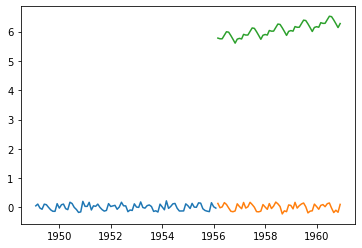

In [57]:
plt.plot(train_time_shift, label='Train')
plt.plot(test_time_shift, label='Test')
plt.plot(forcast_2, label='Prediction')
plt.show()

In [58]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(test_time_shift,forcast_2))
print(rms)

6.0543487915333625


# Building Models

In [76]:
m1 = ARIMA(air_log,order=(2,1,2))

C:\Users\abhay.jamwal\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\abhay.jamwal\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [77]:
result_m1 = m1.fit()

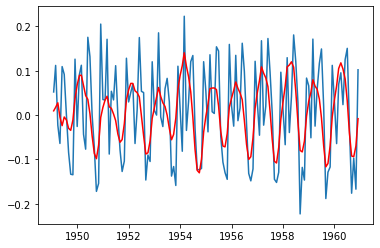

In [78]:
plt.plot(time_shift_trans)
plt.plot(result_m1.fittedvalues,color = 'red')

In [80]:
pred_arima_diff = pd.Series(result_m1.fittedvalues,copy=True)
pred_arima_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64